<a href="https://colab.research.google.com/github/rmaffulli/MI_tutorial/blob/main/MI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Information Theory in neuroscience
Aims of the tutorial:
- Understand the concept of entropy and quantify entropy in a signal
- Binning strategies
- Define mutual information and calculate it for a Poisson spiking neuron
- Bias: origin, implications and mitigation strategies
- The effect of correlated firing on information transmission

Suggested reading for a deeper understanding of the topics covered in this tutorial:
1. Timme, Nicholas M., and Christopher Lapish. "A tutorial for information theory in neuroscience." eneuro 5.3 (2018).
1. Quiroga, R. Q., & Panzeri, S. (2009). Extracting information from neuronal populations: information theory and decoding approaches. Nature Reviews Neuroscience, 10(3), 173-185.
1. Averbeck, B., Latham, P. & Pouget, A. Neural correlations, population coding and computation. Nat Rev Neurosci 7, 358–366 (2006). https://doi.org/10.1038/nrn1888 and references.

---
# Setup

In [154]:
#@title Import
!pip install pydataset
import pydataset
from pydataset import data
import numpy as np
import random as rnd
from matplotlib import pyplot as plt
from scipy.stats import poisson

rnd.seed(2020)

In [3]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/rmaffulli/MI_tutorial/main/figures.mplstyle")

In [181]:
#@title Helper functions
def bin_data(data,nbins,mode):
  if mode == 'eqspaced':
    bins = np.linspace(np.min(data),np.max(data),nbins+1)
    data_binned = np.digitize(data,bins)

    return data_binned

---
# Generation of Poisson spikes
We know that spikes are binary discrete events.
It is often assumed, in first approximation, that each spike is independent of the previous/following one. This implies that the probability of having a spike at a certain time is not influenced by the probability that a spike has occurred previously. This *model* (beware! this is a model the behaviour of a neuron) is consistent with a spike event to be drawn from a Poisson distribution.

*Food for toughts: what are the mechanisms that invalidate the Poisson assumption? Can we think of some reasons to doubt that a spiking neuron is Poissonian?*

In the cell below you can explore the function generating poissonian spike trains.

In [4]:
#@title Spike generation function
def poisson_spike(t,rate):
  # t: time points
  # rate: spiking rate in Hz
  dt = t[1] - t[0];
  sp = np.zeros_like(t)
  for i,tp in enumerate(t):
    if rnd.uniform(0,1) <= dt*rate:
      sp[i] = 1
  
  return sp

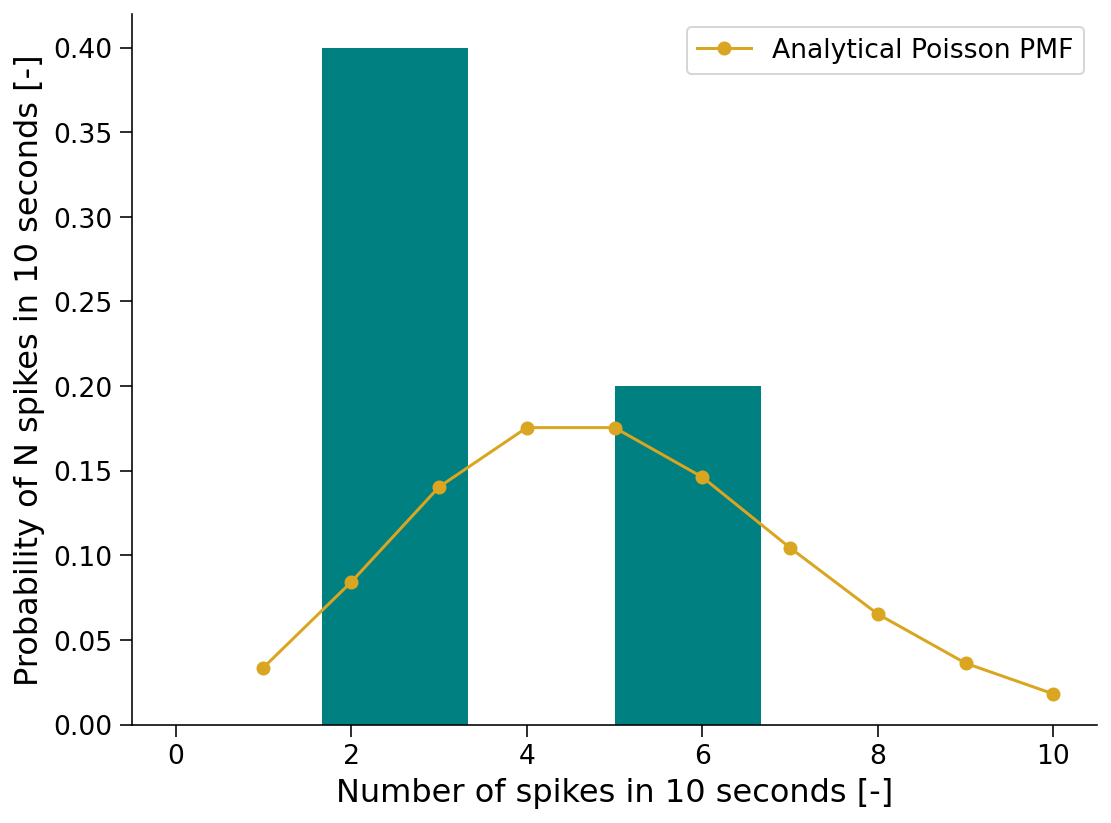

In [5]:
#@title The effect of the number of trials on estimation of probabiltiy mass function { run: "auto" }
trials = 3 #@param {type:"slider", min:1, max:1000, step:1}
rate = 0.5 #@param {type:"slider", min:0.1, max:10, step:0.1}

spike_cnt = np.zeros((trials,))

t = np.linspace(0,10,1000)
for tr in range(trials):
  sp = poisson_spike(t,rate)
  spike_cnt[tr-1] = sum(sp)

_ = plt.hist(spike_cnt,
             range=(0, 2*int(spike_cnt.max())),
             bins=int(spike_cnt.max() + 1),
             density=True, histtype='stepfilled',
             color='teal', edgecolor='none')
x_poisson = np.linspace(1,2*int(spike_cnt.max()),2*int(spike_cnt.max()))
_ = plt.plot(x_poisson, poisson.pmf(x_poisson, rate*10),
             '-o', label='Analytical Poisson PMF',
            color='goldenrod')
plt.xlabel('Number of spikes in 10 seconds [-]')
plt.ylabel('Probability of N spikes in 10 seconds [-]')
_ = plt.legend()

---
# Entropy of a random variable
In this section we will:
- Learn how to calculate the entropy of a random variable
- Understand how the probability distribution of such random variable influences its entropy

Given a Random Variable (RV) $R$, its entropy is defined as:

$H(R) = \sum\limits_{r\in X}p(x)log_2\frac{1}{p(x)}$

in the section below we will implement the following functions:

- `def marginal_p(x):` to calculate the marginal probability of a RV $X$
- `def entropy(x):` to calculate the entropy of $(X)$

In [122]:
def marginal_p(x):
  # returns marginal probabiltiy of random variable X based on observations x
  # x is a 2d matrix: rows are the trials, columns are the response values (considers multi-dimensional responses)
  # find unique values of x and count the number of occurrences across trials
  x_values, p_x = np.unique(x, axis=0, return_counts=True)
  # calculate probabilities of each occurrences
  p_x = p_x/np.shape(x)[0]
  # return probability vector
  return p_x


def entropy(x):
  # returns entropy of random variable X
  # x is a 2d matrix: rows are the trials, columns are the response values (considers multi-dimensional responses)
  # initialize entropy
  ent = 0
  # calculate marginal probability
  p_x = marginal_p(x)
  # calculate entropy
  for p in p_x:
    ent += p*np.log2(1/p)
  # return entropy
  return ent

x = np.asarray([[0, 1],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1]])
print(entropy(x))
if entropy(x) == 1:
  print("Correct! the value of entropy(x) is: " + str(entropy(x)))
else:
  raise NotImplementedError("Wrong values of entropy, double check the implementation of entropy and marginal functions")

1.0
Correct! the value of entropy(x) is: 1.0


Entropy: 5.817645883076827 [bits]


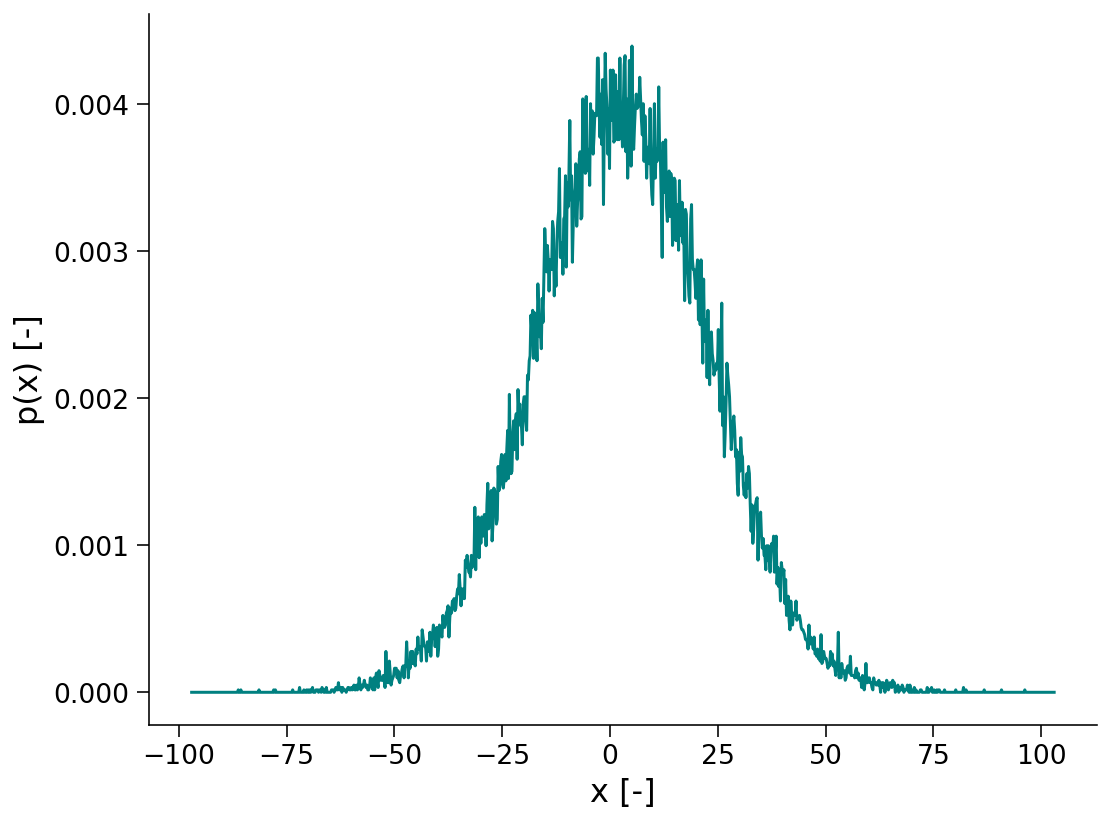

In [123]:
#@title Entropy of a Gaussian random variable { run: "auto" }
mean = 3 #@param {type:"slider", min:-5, max:5, step:1}
std = 20 #@param {type:"slider", min:0.5, max:20, step:0.5}
trials = 61200 #@param {type:"slider", min:100, max:100000, step:100}

x = np.random.normal(mean,std,trials)
bins = np.linspace(mean-100,mean+100,1000)
x_binned = np.zeros_like(bins)
for i in np.digitize(x,bins):
  x_binned[i-1] += 1
p_x = x_binned/sum(x_binned)
_ = plt.plot(bins,p_x,color='teal')
plt.xlabel('x [-]')
plt.ylabel('p(x) [-]')

print("Entropy: " + str(entropy(x_binned)) + " [bits]")

## Discussion
- What is the effect of the standard deviation on entropy? Why? What is the pdf that you expect to carry maximum entropy?
- What is the effect of the mean?
- What is the effect of the number of trials?

---
# Conditional entropy of two random variables
In this section we will:
- Learn how to calculate the conditional entropy of one random variable X given a second variable Y

In the section below we will implement the following functions:

- `def joint_p(x,y):` to calculate the joint probability of $(X;Y)$
- `def conditional_p(x,y):` to calculate the conditional probability of a $(X|Y)$
- `def conditional_entropy(x,y):` to calculate the conditional entropy of $(X|Y)$

In [137]:
def joint_p(x,y):
  # returns joint probabiltiy of random variables (X;Y) based on observations x,y
  # x is a 2d matrix: rows are the trials, columns are the response values (considers multi-dimensional responses)
  # y is a 2d matrix: rows are the trials, columns are the response values (considers multi-dimensional responses)
  # the output value p_xy should be a matrix with rows number equal to the unique values of x and columns number equal to the unique values of y
  # find unique values of x and count the number of occurrences across trials
  x_values, p_x = np.unique(x, axis=0, return_counts=True)
  y_values, p_y = np.unique(y, axis=0, return_counts=True)
  # initialize joint probability matrix
  p_xy = np.zeros((x_values.size, y_values.size))
  # calculate probabilities of each occurrences
  for x_r,y_r in zip(x,y):
    i = np.where(x_values == x_r)
    j = np.where(y_values == y_r)
    p_xy[i,j] += 1

  p_xy = p_xy/np.shape(x)[0]
  # return probability matrix
  return p_xy


def conditional_p(x,y):
  # returns conditional probabiltiy (X|Y) based on observations x,y
  # x is a 2d matrix: rows are the trials, columns are the response values (considers multi-dimensional responses)
  # y is a 2d matrix: rows are the trials, columns are the response values (considers multi-dimensional responses)
  # HINT: use Bayes' formula!!!
  p_xy = joint_p(x,y)
  p_y = marginal_p(y)
  p_x_cond_y = np.zeros_like(p_xy)
  # return conditional probability matrix
  p_x_cond_y = p_xy/p_y[None,:]
  return p_x_cond_y


def conditional_entropy(x,y):
  # returns conditional entropy (X|Y) based on observations x,y
  # x is a 2d matrix: rows are the trials, columns are the response values (considers multi-dimensional responses)
  # y is a 2d matrix: rows are the trials, columns are the response values (considers multi-dimensional responses)
  # initialize entropy
  # calculate joint probability
  p_xy = joint_p(x,y)
  # calculate conditional probability
  p_x_cond_y = conditional_p(x,y)
  # calculate entropy
  cond_entr = np.nansum(np.multiply(p_xy,np.log2(1/p_x_cond_y)))
  # return entropy
  return cond_entr

x = np.asarray([1, 2, 3, 4])
y = np.asarray([1, 1, 2, 2])
if conditional_entropy(x,y) == 1:
  print("Correct! the value of entropy(x) is: " + str(conditional_entropy(x,y)))
else:
  raise NotImplementedError("Wrong values of entropy, double check the implementation of entropy and marginal functions")

Correct! the value of entropy(x) is: 1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply


## Calculate the conditional entropy of real world data
We will now play a bit with real data. We will import a dataset of property prices in the suburbs of Boston and investigate the conditional entropy between a few variables in this dataset.

Source: The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air' J. Environ. Economics & Management, vol.5, 81-102, 1978.

Entropy x =  0.7738064057278412
Entropy y =  2.8816738577729044
Conditional entropy (x|y)) =  0.5136776785557572


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply


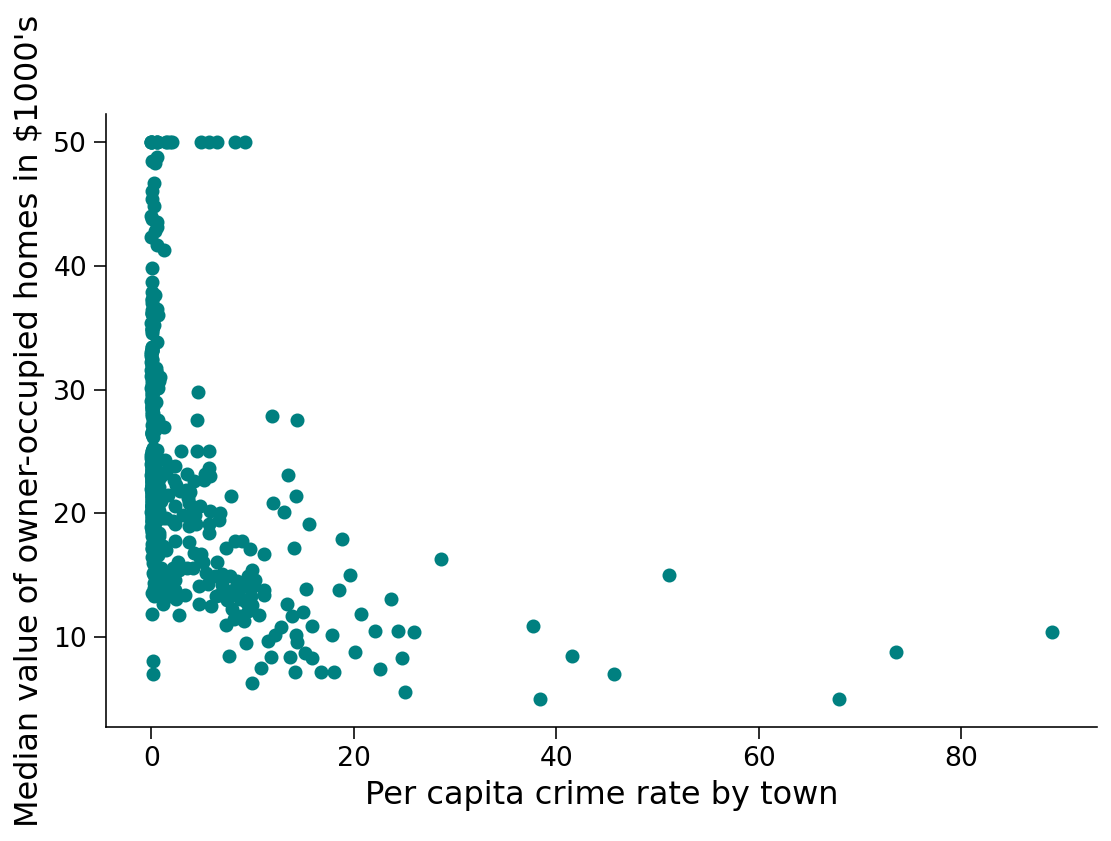

In [188]:
#@{ run: "auto" }
x_var = "crim" #@param ["crim", "nox", "ptratio", "age", "medv"]
y_var = "medv" #@param ["crim", "nox", "ptratio", "age", "medv"]
axis_labels = {
    "crim":"Per capita crime rate by town",
    "nox":"Nitric oxides concentration (parts per 10 million)",
    "ptratio":"Pupil-teacher ratio by town",
    "age":"Proportion of owner-occupied units built prior to 1940",
    "medv":"Median value of owner-occupied homes in $1000's"
}
# Import data
imported_data = data('Boston')
x = imported_data[x_var]
y = imported_data[y_var]

# bin data
x_binned = bin_data(x,10,'eqspaced')
y_binned = bin_data(y,10,'eqspaced')

plt.scatter(x,y,color='teal')
plt.xlabel(axis_labels[x_var])
plt.ylabel(axis_labels[y_var])

print("Entropy x = ", entropy(x_binned))
print("Entropy y = ", entropy(y_binned))
print("Conditional entropy (x|y)) =  "
 + str(conditional_entropy(x_binned,y_binned)))

## A note:
- Never forget that marginal, joint and conditional probability bare related through Bayes rule: $$ p(X|Y) = \frac{p(X,Y)}{p(Y)} $$
so you normally have just to calculate two of them and use Bayes rule to obtain the third one!

## Discussion:
- Can you see a relation between the distributions of X, Y and the conditional entropy $H(X|Y)$?

---
# Mutual Information
In this section we will:
- Learn how to calculate the mutual information between signal and response for two Poisson spiking neurons
in the section below we will implement the following functions:

- `def mi(x,y):` to calculate the mutual information of $(X;Y)$

---
# A digression on binning
In this section we will:
- Discuss the effects of number of bins on the calculation of MI
- Consider the difference between binning strategies

---
# Bias and bias correction strategies
In this section we will:
- Demonstrate the effect of bias on the calculation of MI
- Implement quadratic extrapolation for bias correction

---
# Effect of noise correlations in population coding
In this section we will:
- Define the response of 2 neurons to 2 different stimuli and see how noise correlations affect their response:
  - Can we build an hypothesis about the effect on noise correlations on information in neuronal populations?
- Discuss the problems arising from looking at multi-dimensional responses
- Confirm/discard our hypothesis on the effect of noise correlations on information in neuronal populations through numerical calculations
